<a href="https://colab.research.google.com/github/Dedalus1982/MIPHI_Kurs_Classik_ML/blob/main/code%20/Kurs_classic_DAF_CC50_regress_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка данных:

In [ ]:
!pip install catboost -q
!pip install optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 11.2 MB/s eta 0:00:00


In [ ]:
# Подключение к Google Drive и работа с файлами
from google.colab import drive
drive.mount('/content/drive')

# Библиотеки для работы с данными
import pandas as pd
import numpy as np

# Библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

# Статистические методы
from scipy.stats import mannwhitneyu

# Машинное обучение
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# Регрессоры
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import TweedieRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.base import clone


# Метрики
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, explained_variance_score, max_error, make_scorer

# Регрессия с трансформацией цели
from sklearn.compose import TransformedTargetRegressor

from pickle import TRUE
import os
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
import joblib

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/'
handmade = pd.read_csv(os.path.join(data_dir,'df_handmade.csv')).drop(columns=['SI', 'IC50'])
pca = pd.read_csv(os.path.join(data_dir,'pca_cleaned_CC50.csv'))
tsne = pd.read_csv(os.path.join(data_dir,'tsne_cleaned_CC50.csv'))
umap = pd.read_csv(os.path.join(data_dir,'umap_cleaned_CC50.csv'))

In [ ]:
# @title Подготовка данных для моделирования
analyse_name = 'regres_mae'
base_parameter = 'CC50'

# подготовка данных для handmade
metod_name_1 = 'handmade'
X1 = handmade.drop(columns=[base_parameter])
y1 = handmade[base_parameter]

base_name1 = f"{base_parameter}_{analyse_name}_{metod_name_1}"
table_1 = f"table_{base_name1}.csv"
final_1 = f"{base_name1}_"

# подготовка данных для pca
metod_name_2 = 'pca'
X2 = pca.drop(columns=[base_parameter])
y2 = pca[base_parameter]

base_name2 = f"{base_parameter}_{analyse_name}_{metod_name_2}"
table_2 = f"table_{base_name2}.csv"
final_2 = f"{base_name2}_"

# подготовка данных для tsne
metod_name_3 = 'tsne'
X3 = tsne.drop(columns=[base_parameter])
y3 = tsne[base_parameter]

base_name3 = f"{base_parameter}_{analyse_name}_{metod_name_3}"
table_3 = f"table_{base_name3}.csv"
final_3 = f"{base_name3}_"

# подготовка данных для umap
metod_name_4 = 'umap'
X4 = umap.drop(columns=[base_parameter])
y4 = umap[base_parameter]

base_name4 = f"{base_parameter}_{analyse_name}_{metod_name_4}"
table_4 = f"table_{base_name4}.csv"
final_4 = f"{base_name4}_"

# название файла с хранением всех результатов
csv_file_final = f"{analyse_name}_{base_parameter}.csv"

# МОДЕЛИРОВАНИЕ

In [ ]:
# @title класс RegressionModelEvaluator для анализа моделей регрессии

class RegressionModelEvaluator:
    def __init__(self, X, y, test_size=0.2, random_state=42,
                 log_target=False, models_config=None, metod_name="", data_dir=None):
        self.X = X.copy()
        self.y = y.copy()
        self.test_size = test_size
        self.random_state = random_state
        self.log_target = log_target
        self.models = {}
        self.results = None
        self.best_model = None
        self.metod_name = metod_name
        self.grid_search_results = {}
        self.data_dir = data_dir or '/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/'

        # Проверка данных
        if log_target and (self.y <= 0).any():
            raise ValueError("все значения y должны быть положительными")

        # Логарифмирование целевой переменной
        epsilon = 1e-8
        self.y_transformed = np.log1p(self.y + epsilon) if log_target else self.y

        # Разделение данных
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y_transformed,
            test_size=test_size,
            random_state=random_state
        )

        # Инициализация моделей
        self.models = models_config or self.create_models_config()

    def create_models_config(self):
        return {
            # Линейные модели с регуляризацией: Ridge, Lasso, ElasticNet
            'Ridge': {
                'model': make_pipeline(
                    StandardScaler(),
                    PolynomialFeatures(degree=2, include_bias=False),
                    Ridge()
                ),
                'params': {'ridge__alpha': [0.01, 0.1, 1, 10, 100]}
            },
            'Lasso': {
                'model': make_pipeline(
                    StandardScaler(),
                    PolynomialFeatures(degree=2, include_bias=False),
                    Lasso()
                ),
                'params': {'lasso__alpha': [0.0001, 0.001, 0.01, 0.1, 1]}
            },
            'ElasticNet': {
                'model': make_pipeline(
                    StandardScaler(),
                    PolynomialFeatures(degree=2, include_bias=False),
                    ElasticNet()
                ),
                'params': {
                    'elasticnet__alpha': [0.0001, 0.001, 0.01, 0.1],
                    'elasticnet__l1_ratio': [0.2, 0.5, 0.8]
                }
            },
            # Метод опорных векторов (SVR)
            'SVR': {
                'model': make_pipeline(
                    StandardScaler(),
                    SVR()
                ),
                'params': {
                    'svr__kernel': ['linear', 'rbf', 'poly'],
                    'svr__C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                    'svr__epsilon': [0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5]
                }
            },
            # Метод k-ближайших соседей (KNN)
            'KNN': {
                'model': make_pipeline(
                    StandardScaler(),
                    KNeighborsRegressor()
                ),
                'params': {
                    'kneighborsregressor__n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
                    'kneighborsregressor__weights': ['uniform', 'distance'],
                    'kneighborsregressor__p': [1, 2]  # 1 - манхэттенское расстояние, 2 - евклидово
                }
            },
            # модели деревьев
            'DecisionTree': {
                'model': DecisionTreeRegressor(random_state=self.random_state),
                'params': {
                    'max_depth': [None, 5, 10, 20, 30],
                    'min_samples_split': [2, 5, 10],
                    'min_samples_leaf': [1, 2, 4]
                }
            },
            'ExtraTrees': {
                'model': ExtraTreesRegressor(random_state=self.random_state),
                'params': {
                    'n_estimators': [100, 200, 300, 400],
                    'max_depth': [None, 5, 10, 20, 30],
                    'min_samples_split': [2, 5]
                }
            },
            'RandomForest': {
                'model': RandomForestRegressor(random_state=self.random_state),
                'params': {
                    'n_estimators': [100, 200, 300, 400],
                    'max_depth': [None, 5, 10, 20, 30],
                    'min_samples_split': [2, 5],
                    'max_features': ['sqrt', 0.8]
                }
            },
            # Бустеры
            'GradientBoosting': {
                'model': GradientBoostingRegressor(random_state=self.random_state),
                'params': {
                    'n_estimators': [100, 200, 300, 400],
                    'learning_rate': [0.05, 0.1, 0.2],
                    'max_depth': [3, 5, 7],
                    'min_samples_split': [2, 5]
                }
            },
            'HistGradientBoosting': {
                'model': HistGradientBoostingRegressor(random_state=self.random_state),
                'params': {
                    'max_iter': [100, 200, 300, 400],
                    'learning_rate': [0.05, 0.1],
                    'max_depth': [None, 5, 10],
                    'min_samples_leaf': [10, 20]
                }
            },
            'XGBoost': {
                'model': XGBRegressor(random_state=self.random_state),
                'params': {
                    'n_estimators': [100, 200, 300, 400],
                    'learning_rate': [0.05, 0.1],
                    'max_depth': [3, 5, 7],
                    'subsample': [0.8, 1.0],
                    'colsample_bytree': [0.8, 1.0]
                }
            },
            'CatBoost': {
                'model': CatBoostRegressor(random_state=self.random_state, silent=True),
                'params': {
                    'iterations': [100, 200, 300, 400],
                    'learning_rate': [0.05, 0.1],
                    'depth': [3, 5, 7],
                    'l2_leaf_reg': [3, 5, 7]
                }
            },
            # МОДЕЛИ ДЛЯ ГАММА-РАСПРЕДЕЛЕНИЯ
            #'GLM_Gamma': {
            #    'model': make_pipeline(
            #        StandardScaler(),
            #        TweedieRegressor(power=2, link='log', max_iter=1000)
            #    ),
            #   'params': {
            #       'tweedieregressor__alpha': [0.001, 0.01, 0.1, 1],
            #       'tweedieregressor__max_iter': [1000]
            #   }
            #},
            'XGBoost_Tweedie': {
                'model': XGBRegressor(objective='reg:tweedie', random_state=self.random_state),
                'params': {
                    'n_estimators': [100, 200, 300, 400],
                    'learning_rate': [0.05, 0.1],
                    'max_depth': [3, 5, 7],
                    'subsample': [0.8, 1.0],
                    'colsample_bytree': [0.8, 1.0],
                    'tweedie_variance_power': [1.1, 1.3, 1.5, 1.7, 1.9]
                }
            },
            'CatBoost_Tweedie': {
                'model': CatBoostRegressor(random_state=self.random_state, silent=True),
                'params': {
                    'loss_function': [
                        'Tweedie:variance_power=1.1',
                        'Tweedie:variance_power=1.3',
                        'Tweedie:variance_power=1.5',
                        'Tweedie:variance_power=1.7',
                        'Tweedie:variance_power=1.9'
                        ],
                    'iterations': [100, 200, 300, 400],
                    'learning_rate': [0.05, 0.1],
                    'depth': [3, 5, 7],
                    'l2_leaf_reg': [3, 5, 7]
                }
            }
        }
        return models_config

    def evaluate_models(self, verbose=False, auto_save_metrics=True, metrics_filename='all_models_metrics.csv'):
        results = []
        self.grid_search_results = {}

        # Функция для RMSE
        def rmse(y_true, y_pred):
            return np.sqrt(mean_squared_error(y_true, y_pred))

        # make_scorer на основе RMSE
        rmse_scorer = make_scorer(rmse, greater_is_better=False)

        for name, model_info in self.models.items():
            if verbose:
                print(f"Подбор параметров {name}...")

            model = model_info['model']
            params = model_info['params']

            # Подбор параметров
            gs = GridSearchCV(
                model,
                params,
                cv=KFold(n_splits=3, shuffle=True, random_state=self.random_state),
                scoring='neg_mean_absolute_error',
                n_jobs=-1,
                verbose=0
            )
            gs.fit(self.X_train, self.y_train)
            self.grid_search_results[name] = gs

            # Лучшая модель
            best_model = gs.best_estimator_
            best_params = gs.best_params_
            cv_score = -gs.best_score_

            # Предсказания
            y_pred = best_model.predict(self.X_test)

            # Метрики
            metrics = {
                'Model': name,
                'Metod': self.metod_name,
                'Best Parameters': best_params,
                'CV MSE': cv_score,
                'Test MSE': mean_squared_error(self.y_test, y_pred),
                'Test RMSE': rmse(self.y_test, y_pred),
                'Test MAE': mean_absolute_error(self.y_test, y_pred),
                'Test R2': r2_score(self.y_test, y_pred),
                'Test Explained Variance': explained_variance_score(self.y_test, y_pred),
                'Test Max Error': max_error(self.y_test, y_pred),
                'Test MAPE': mean_absolute_percentage_error(self.y_test, y_pred),
                'Log Target': self.log_target,
                'Model Object': best_model
            }
            # если целевая переменная была логарифмирована - нужно добавить экспонированные метрики
            if self.log_target:
                y_true_inv = np.expm1(self.y_test)
                y_pred_inv = np.expm1(y_pred)
                metrics['Test MSE (invlog)'] = mean_squared_error(y_true_inv, y_pred_inv)
                metrics['Test MAE (invlog)'] = mean_absolute_error(y_true_inv, y_pred_inv)
                metrics['Test RMSE (invlog)'] = rmse(y_true_inv, y_pred_inv)

            results.append(metrics)

            if verbose:
                print(f"выполнено: Test MAE: {metrics['Test MAE']:.3f}")

        # Сохраняем результаты
        self.results = pd.DataFrame(results).set_index('Model').sort_values('Test MAE')

        if auto_save_metrics:
            self._save_all_models_metrics(metrics_filename)

        return self.results


    def _save_all_models_metrics(self, filename='all_models_metrics.csv'):
        if self.results is None:
            raise ValueError("Нет результатов для сохранения")
        os.makedirs(self.data_dir, exist_ok=True)
        filepath = os.path.join(self.data_dir, filename)
        self.results.to_csv(filepath)
        print(f"Метрики всех моделей сохранены в {filepath}")
        return filepath

    def get_top_models(self, n=3):
        if self.results is None:
            raise ValueError("Сначала evaluate_models()")

        top_models = []
        for model_name in self.results.index[:n]:
            gs = self.grid_search_results[model_name]
            best_model = gs.best_estimator_

            # Обучаем на всём датасете
            final_model = clone(best_model)
            final_model.fit(self.X, self.y)

            # Вычисляем метрики на тестовом наборе
            metrics = self.results.loc[model_name].to_dict()

            top_models.append({
                'name': model_name,
                'model': final_model,
                'metrics': metrics
            })

        return top_models

    def save_top_models(self, n=3, prefix='model_'):
        if self.results is None:
            raise ValueError("Сначала evaluate_models()")

        os.makedirs(self.data_dir, exist_ok=True)
        top_models = self.get_top_models(n)

        saved_files = []
        for model_info in top_models:
            filename = f"{prefix}{model_info['name'].lower().replace(' ', '_')}.pkl"
            filepath = os.path.join(self.data_dir, filename)

            joblib.dump(model_info['model'], filepath)
            saved_files.append(filepath)
            print(f"Модель {model_info['name']} сохранена в {filepath}")

        metrics_filename = f"{prefix}metrics.csv"
        metrics_filepath = os.path.join(self.data_dir, metrics_filename)

        metrics_data = []
        for model_info in top_models:
            metrics = model_info['metrics']
            metrics.pop('Best Parameters', None)
            metrics_data.append(metrics)

        metrics_df = pd.DataFrame(metrics_data)
        metrics_df.to_csv(metrics_filepath, index=False)
        print(f"Метрики топ-{n} моделей сохранены в {metrics_filepath}")

        return {
            'model_files': saved_files,
            'metrics_file': metrics_filepath
        }

    def predict(self, X):
        if self.best_model is None:
            raise ValueError("Сначала выполните evaluate_models()")
        preds = self.best_model[0].predict(X)

        if self.log_target:
            return np.expm1(preds)
        return preds


In [ ]:
# @title класс RegressionResultsVisualizer для анализа моделей регрессии

class RegressionResultsVisualizer:
    def __init__(self, evaluator):
        self.evaluator = evaluator
        self.results = evaluator.results.sort_values('Test MSE')  # Сортируем по MSE
        sns.set_style("whitegrid")

    def plot_metrics_comparison(self, ax=None):
        """Горизонтальный barplot с метриками"""
        if ax is None:
            ax = plt.gca()

        metrics = ['Test RMSE', 'Test MAE', 'Test MAPE']
        plot_df = self.results[metrics].sort_values('Test MAE')
        plot_df.plot(kind='barh', ax=ax)
        ax.set_title("Сравнение метрик моделей")
        ax.legend(loc='lower right')

    def plot_predictions(self, model_name, ax=None):
        """Scatterplot предсказаний vs реальных значений"""
        if ax is None:
            ax = plt.gca()

        model = self.evaluator.grid_search_results[model_name].best_estimator_
        y_pred = model.predict(self.evaluator.X_test)

        if self.evaluator.log_target:
            y_test = np.expm1(self.evaluator.y_test)
            y_pred = np.expm1(y_pred)
        else:
            y_test = self.evaluator.y_test

        sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, ax=ax)
        ax.plot([y_test.min(), y_test.max()],
                [y_test.min(), y_test.max()],
                'r--', label='Идеальная линия')
        ax.set_title(f"Предсказания vs Факт: {model_name}")
        ax.legend()

    def plot_error_distributions(self, model_names, ax=None):
        """KDE plot ошибок для нескольких моделей"""
        if ax is None:
            ax = plt.gca()

        for model_name in model_names:
            model = self.evaluator.grid_search_results[model_name].best_estimator_
            y_pred = model.predict(self.evaluator.X_test)

            if self.evaluator.log_target:
                y_test = np.expm1(self.evaluator.y_test)
                y_pred = np.expm1(y_pred)
            else:
                y_test = self.evaluator.y_test

            errors = y_pred - y_test
            sns.kdeplot(errors, label=model_name, ax=ax)

        ax.axvline(0, color='red', linestyle='--', label='Нет ошибки')
        ax.set_title("Распределение ошибок")
        ax.legend()

    def visualize_all(self, top_n=3):
        """Визуализация в одну строку: метрики, предсказания, ошибки"""
        plt.figure(figsize=(18, 5))  # Широкая фигура для 3 графиков

        # 1. График метрик
        plt.subplot(1, 3, 1)
        self.plot_metrics_comparison()

        # 2. Предсказания лучшей модели
        plt.subplot(1, 3, 2)
        best_model = self.results.index[0]
        self.plot_predictions(best_model)

        # 3. Распределение ошибок топ-N моделей
        plt.subplot(1, 3, 3)
        top_models = self.results.index[:top_n].tolist()
        self.plot_error_distributions(top_models)

        plt.tight_layout()
        plt.show()

Подбор параметров Ridge...
выполнено: Test MAE: 1.505
Подбор параметров Lasso...
выполнено: Test MAE: 1.093
Подбор параметров ElasticNet...
выполнено: Test MAE: 0.945
Подбор параметров SVR...
выполнено: Test MAE: 0.901
Подбор параметров KNN...
выполнено: Test MAE: 0.844
Подбор параметров DecisionTree...
выполнено: Test MAE: 1.074
Подбор параметров ExtraTrees...
выполнено: Test MAE: 0.849
Подбор параметров RandomForest...
выполнено: Test MAE: 0.849
Подбор параметров GradientBoosting...
выполнено: Test MAE: 0.879
Подбор параметров HistGradientBoosting...
выполнено: Test MAE: 0.925
Подбор параметров XGBoost...
выполнено: Test MAE: 0.850
Подбор параметров CatBoost...
выполнено: Test MAE: 0.860
Подбор параметров XGBoost_Tweedie...
выполнено: Test MAE: 0.862
Подбор параметров CatBoost_Tweedie...
выполнено: Test MAE: 0.901
Метрики всех моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/table_CC50_regres_mae_handmade.csv


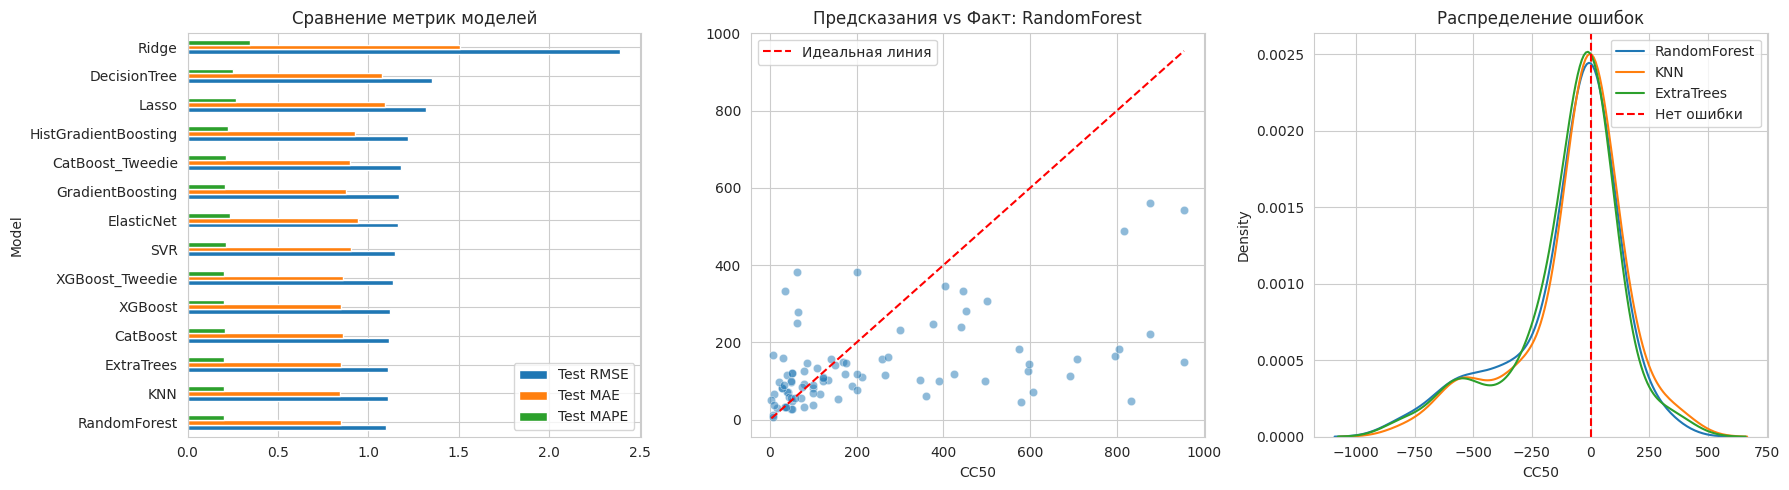

Модель KNN сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_regres_mae_handmade_knn.pkl
Модель ExtraTrees сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_regres_mae_handmade_extratrees.pkl
Модель RandomForest сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_regres_mae_handmade_randomforest.pkl
Модель XGBoost сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_regres_mae_handmade_xgboost.pkl
Модель CatBoost сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_regres_mae_handmade_catboost.pkl
Метрики топ-5 моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_regres_mae_handmade_metrics.csv


In [ ]:
# @title Тест моделей на ручных данных
# инициализация
evaluator_handmade = RegressionModelEvaluator(X1, y1, metod_name=metod_name_1, log_target=True) # ПОМЕНЯТЬ ТУТ!
results = evaluator_handmade.evaluate_models(verbose=True, metrics_filename=table_1)
results_handmade = results.copy()

# Диаграмки
visualizer = RegressionResultsVisualizer(evaluator_handmade)
visualizer.visualize_all()

# Сохранение топ-3 моделей
saved_files = evaluator_handmade.save_top_models(n=5, prefix=final_1)

In [ ]:
results_handmade.head(5)

,Metod,Best Parameters,CV MSE,Test MSE,Test RMSE,Test MAE,Test R2,Test Explained Variance,Test Max Error,Test MAPE,Log Target,Model Object,Test MSE (invlog),Test MAE (invlog),Test RMSE (invlog)
Model,,,,,,,,,,,,,,,
KNN,handmade,"{'kneighborsregressor__n_neighbors': 5, 'kneig...",1.064488,1.229404,1.108785,0.843695,0.271638,0.277380,3.426445,0.202741,True,"(StandardScaler(), KNeighborsRegressor(p=1, we...",57711.815661,152.673998,240.232836
ExtraTrees,handmade,"{'max_depth': 20, 'min_samples_split': 5, 'n_e...",1.038936,1.233841,1.110784,0.849121,0.269009,0.292562,3.213440,0.203129,True,"(ExtraTreeRegressor(max_depth=20, min_samples_...",61706.393625,155.455426,248.407717
RandomForest,handmade,"{'max_depth': None, 'max_features': 'sqrt', 'm...",1.053291,1.205403,1.097909,0.849412,0.285857,0.300363,3.081254,0.203846,True,"(DecisionTreeRegressor(max_features='sqrt', ra...",65017.279890,161.217721,254.984862
XGBoost,handmade,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",1.050137,1.252466,1.119136,0.849700,0.257974,0.272579,3.587140,0.203947,True,"XGBRegressor(base_score=None, booster=None, ca...",60498.393671,152.754452,245.964212
CatBoost,handmade,"{'depth': 7, 'iterations': 200, 'l2_leaf_reg':...",1.048717,1.241360,1.114163,0.860352,0.264555,0.280603,3.369426,0.206956,True,<catboost.core.CatBoostRegressor object at 0x7...,62360.398741,159.225961,249.720641


Подбор параметров Ridge...
выполнено: Test MAE: 0.966
Подбор параметров Lasso...
выполнено: Test MAE: 0.983
Подбор параметров ElasticNet...
выполнено: Test MAE: 0.969
Подбор параметров SVR...
выполнено: Test MAE: 0.871
Подбор параметров KNN...
выполнено: Test MAE: 0.846
Подбор параметров DecisionTree...
выполнено: Test MAE: 1.078
Подбор параметров ExtraTrees...
выполнено: Test MAE: 0.887
Подбор параметров RandomForest...
выполнено: Test MAE: 0.914
Подбор параметров GradientBoosting...
выполнено: Test MAE: 0.892
Подбор параметров HistGradientBoosting...
выполнено: Test MAE: 0.880
Подбор параметров XGBoost...
выполнено: Test MAE: 0.912
Подбор параметров CatBoost...
выполнено: Test MAE: 0.896
Подбор параметров XGBoost_Tweedie...
выполнено: Test MAE: 0.927
Подбор параметров CatBoost_Tweedie...
выполнено: Test MAE: 0.949
Метрики всех моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/table_CC50_regres_mae_pca.csv


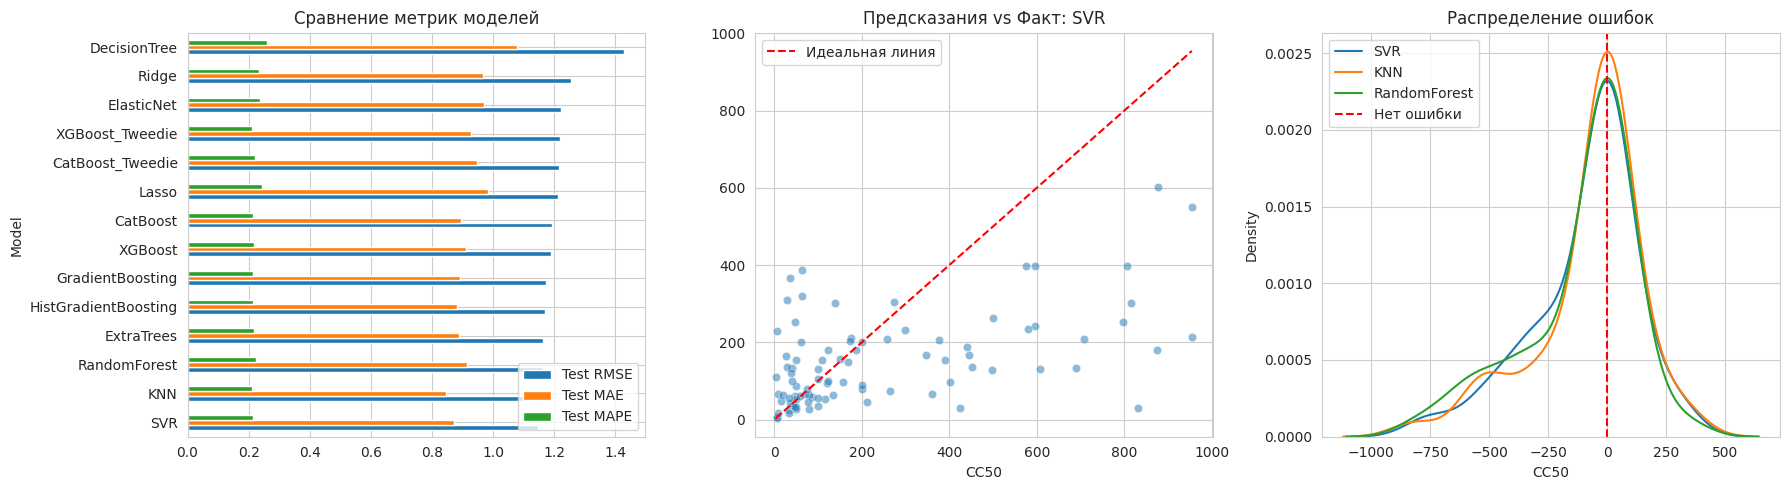

Модель KNN сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_regres_mae_pca_knn.pkl
Модель SVR сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_regres_mae_pca_svr.pkl
Модель HistGradientBoosting сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_regres_mae_pca_histgradientboosting.pkl
Модель ExtraTrees сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_regres_mae_pca_extratrees.pkl
Модель GradientBoosting сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_regres_mae_pca_gradientboosting.pkl
Метрики топ-5 моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_regres_mae_pca_metrics.csv


In [ ]:
# @title Тест моделей на данных pca
# инициализация
evaluator_pca = RegressionModelEvaluator(X2, y2, metod_name=metod_name_2, log_target=True) # ПОМЕНЯТЬ ТУТ!
results = evaluator_pca.evaluate_models(verbose=True, metrics_filename=table_2)
results_pca = results.copy()

# Диаграмки
visualizer = RegressionResultsVisualizer(evaluator_pca)
visualizer.visualize_all()

# Сохранение топ-3 моделей
saved_files = evaluator_pca.save_top_models(n=5, prefix=final_2)

In [ ]:
results_pca.head(5)

,Metod,Best Parameters,CV MSE,Test MSE,Test RMSE,Test MAE,Test R2,Test Explained Variance,Test Max Error,Test MAPE,Log Target,Model Object,Test MSE (invlog),Test MAE (invlog),Test RMSE (invlog)
Model,,,,,,,,,,,,,,,
KNN,pca,"{'kneighborsregressor__n_neighbors': 9, 'kneig...",1.055640,1.332409,1.154300,0.846363,0.210612,0.211210,3.505616,0.212413,True,"(StandardScaler(), KNeighborsRegressor(n_neigh...",58863.769474,151.825385,242.618568
SVR,pca,"{'svr__C': 3, 'svr__epsilon': 0.5, 'svr__kerne...",1.041293,1.311591,1.145247,0.870590,0.222946,0.231387,3.385645,0.215074,True,"(StandardScaler(), SVR(C=3, epsilon=0.5))",59782.616276,161.612767,244.504839
HistGradientBoosting,pca,"{'learning_rate': 0.05, 'max_depth': 10, 'max_...",1.071116,1.366549,1.168995,0.880363,0.190386,0.204372,3.234515,0.214848,True,HistGradientBoostingRegressor(learning_rate=0....,61172.076477,155.411394,247.329894
ExtraTrees,pca,"{'max_depth': 20, 'min_samples_split': 5, 'n_e...",1.048279,1.354249,1.163722,0.886690,0.197673,0.211684,3.158776,0.216365,True,"(ExtraTreeRegressor(max_depth=20, min_samples_...",63728.087527,159.893295,252.444227
GradientBoosting,pca,"{'learning_rate': 0.05, 'max_depth': 5, 'min_s...",1.080307,1.379088,1.174346,0.891554,0.182958,0.201288,3.037251,0.214313,True,([DecisionTreeRegressor(criterion='friedman_ms...,65780.959237,162.248036,256.477990


Подбор параметров Ridge...
выполнено: Test MAE: 1.079
Подбор параметров Lasso...
выполнено: Test MAE: 1.093
Подбор параметров ElasticNet...
выполнено: Test MAE: 1.099
Подбор параметров SVR...
выполнено: Test MAE: 1.066
Подбор параметров KNN...
выполнено: Test MAE: 0.958
Подбор параметров DecisionTree...
выполнено: Test MAE: 1.143
Подбор параметров ExtraTrees...
выполнено: Test MAE: 0.987
Подбор параметров RandomForest...
выполнено: Test MAE: 0.943
Подбор параметров GradientBoosting...
выполнено: Test MAE: 1.058
Подбор параметров HistGradientBoosting...
выполнено: Test MAE: 0.956
Подбор параметров XGBoost...
выполнено: Test MAE: 0.973
Подбор параметров CatBoost...
выполнено: Test MAE: 0.945
Подбор параметров XGBoost_Tweedie...
выполнено: Test MAE: 1.046
Подбор параметров CatBoost_Tweedie...
выполнено: Test MAE: 0.989
Метрики всех моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/table_CC50_regres_mae_tsne.csv


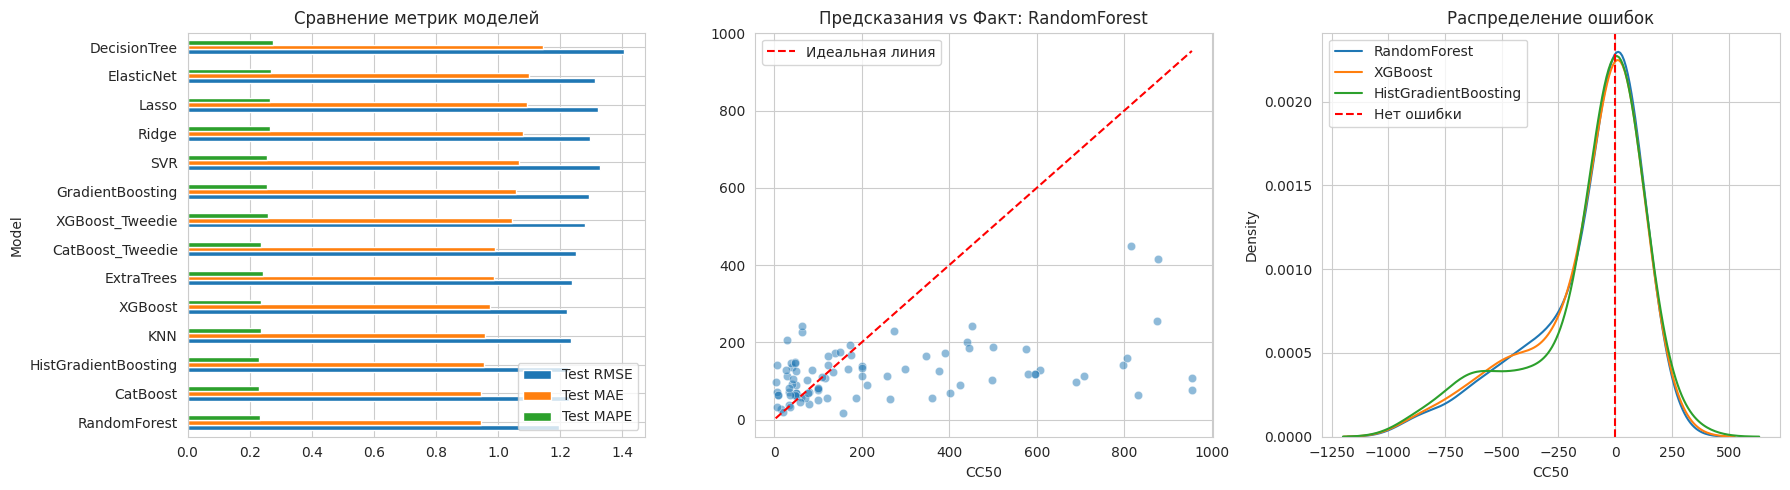

Модель RandomForest сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_regres_mae_tsne_randomforest.pkl
Модель CatBoost сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_regres_mae_tsne_catboost.pkl
Модель HistGradientBoosting сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_regres_mae_tsne_histgradientboosting.pkl
Модель KNN сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_regres_mae_tsne_knn.pkl
Модель XGBoost сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_regres_mae_tsne_xgboost.pkl
Метрики топ-5 моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_regres_mae_tsne_metrics.csv


In [ ]:
# @title Тест моделей на ОЧИЩЕННЫХ от выбросов даннык, масштабированных tSME(3 параметра)
# инициализация
evaluator_tsne = RegressionModelEvaluator(X3, y3, metod_name=metod_name_3, log_target=True) # ПОМЕНЯТЬ ТУТ!
results = evaluator_tsne.evaluate_models(verbose=True, metrics_filename=table_3)
results_tsne = results.copy()

# Диаграмки
visualizer = RegressionResultsVisualizer(evaluator_tsne)
visualizer.visualize_all()

# Сохранение топ-3 моделей
saved_files = evaluator_tsne.save_top_models(n=5, prefix=final_3)

In [ ]:
results_tsne.head(5)

,Metod,Best Parameters,CV MSE,Test MSE,Test RMSE,Test MAE,Test R2,Test Explained Variance,Test Max Error,Test MAPE,Log Target,Model Object,Test MSE (invlog),Test MAE (invlog),Test RMSE (invlog)
Model,,,,,,,,,,,,,,,
RandomForest,tsne,"{'max_depth': None, 'max_features': 'sqrt', 'm...",1.178504,1.425784,1.194062,0.943464,0.155292,0.174702,3.084427,0.232097,True,"(DecisionTreeRegressor(max_features='sqrt', ra...",75011.967528,173.239154,273.883127
CatBoost,tsne,"{'depth': 7, 'iterations': 300, 'l2_leaf_reg':...",1.172967,1.507086,1.227634,0.944805,0.107125,0.131315,3.384884,0.229635,True,<catboost.core.CatBoostRegressor object at 0x7...,76241.797988,171.346061,276.119174
HistGradientBoosting,tsne,"{'learning_rate': 0.05, 'max_depth': 5, 'max_i...",1.243551,1.497115,1.223566,0.955525,0.113032,0.134942,3.061550,0.231460,True,HistGradientBoostingRegressor(learning_rate=0....,82908.886454,177.071272,287.939033
KNN,tsne,"{'kneighborsregressor__n_neighbors': 5, 'kneig...",1.112416,1.524699,1.234787,0.958122,0.096690,0.110692,3.673709,0.234945,True,"(StandardScaler(), KNeighborsRegressor(p=1, we...",64904.025979,167.127892,254.762686
XGBoost,tsne,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",1.196877,1.495521,1.222915,0.972532,0.113977,0.137843,3.295750,0.237519,True,"XGBRegressor(base_score=None, booster=None, ca...",78864.924979,177.367200,280.828996


Подбор параметров Ridge...
выполнено: Test MAE: 1.020
Подбор параметров Lasso...
выполнено: Test MAE: 1.021
Подбор параметров ElasticNet...
выполнено: Test MAE: 1.017
Подбор параметров SVR...
выполнено: Test MAE: 1.061
Подбор параметров KNN...
выполнено: Test MAE: 0.920
Подбор параметров DecisionTree...
выполнено: Test MAE: 1.005
Подбор параметров ExtraTrees...
выполнено: Test MAE: 0.908
Подбор параметров RandomForest...
выполнено: Test MAE: 0.936
Подбор параметров GradientBoosting...
выполнено: Test MAE: 0.954
Подбор параметров HistGradientBoosting...
выполнено: Test MAE: 0.926
Подбор параметров XGBoost...
выполнено: Test MAE: 0.958
Подбор параметров CatBoost...
выполнено: Test MAE: 0.931
Подбор параметров XGBoost_Tweedie...
выполнено: Test MAE: 0.954
Подбор параметров CatBoost_Tweedie...
выполнено: Test MAE: 0.912
Метрики всех моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/table_CC50_regres_mae_umap.csv


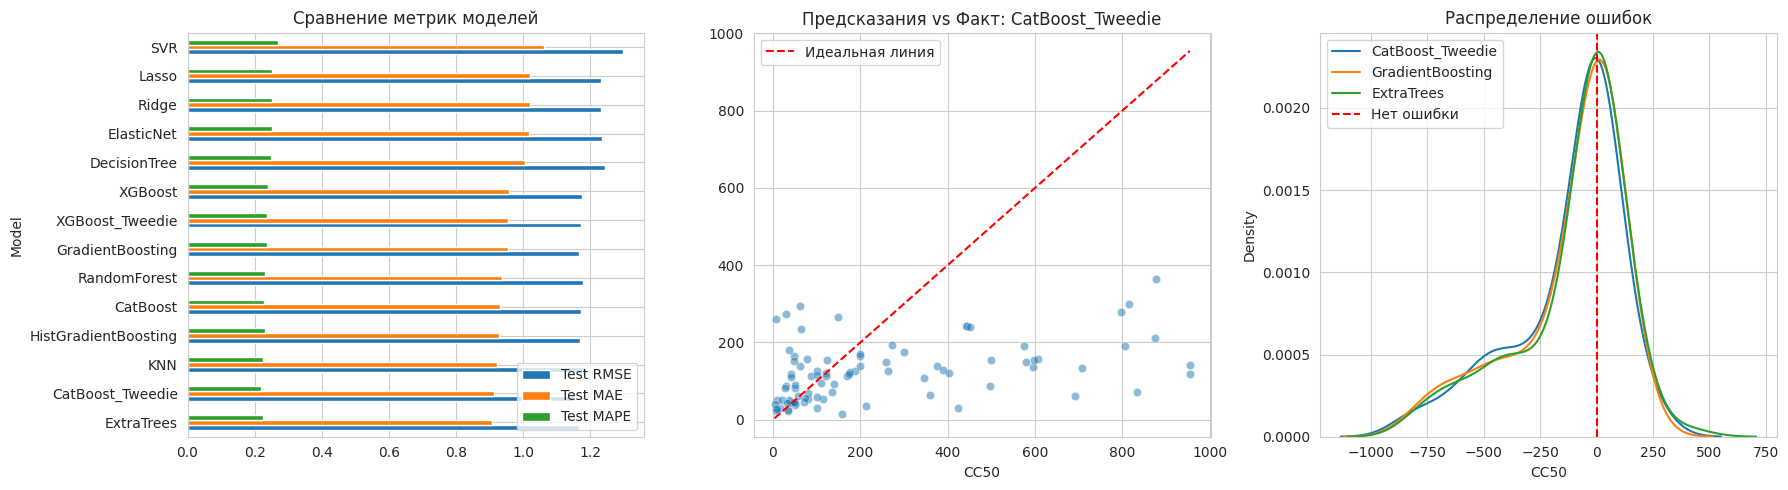

Модель ExtraTrees сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_regres_mae_umap_extratrees.pkl
Модель CatBoost_Tweedie сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_regres_mae_umap_catboost_tweedie.pkl
Модель KNN сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_regres_mae_umap_knn.pkl
Модель HistGradientBoosting сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_regres_mae_umap_histgradientboosting.pkl
Модель CatBoost сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_regres_mae_umap_catboost.pkl
Метрики топ-5 моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_regres_mae_umap_metrics.csv


In [ ]:
# @title Тест моделей на ОЧИЩЕННЫХ от выбросов даннык, масштабированных UMAP(3 параметра)
# инициализация
evaluator_umap = RegressionModelEvaluator(X4, y4, metod_name=metod_name_4, log_target=True) # ПОМЕНЯТЬ ТУТ!
results = evaluator_umap.evaluate_models(verbose=True, metrics_filename=table_4)
results_umap = results.copy()

# Диаграмки
visualizer = RegressionResultsVisualizer(evaluator_umap)
visualizer.visualize_all()

# Сохранение топ-3 моделей
saved_files = evaluator_umap.save_top_models(n=5, prefix=final_4)

In [ ]:
results_umap.head(5)

,Metod,Best Parameters,CV MSE,Test MSE,Test RMSE,Test MAE,Test R2,Test Explained Variance,Test Max Error,Test MAPE,Log Target,Model Object,Test MSE (invlog),Test MAE (invlog),Test RMSE (invlog)
Model,,,,,,,,,,,,,,,
ExtraTrees,umap,"{'max_depth': 10, 'min_samples_split': 5, 'n_e...",1.116274,1.361429,1.166803,0.908221,0.193420,0.203188,3.129871,0.223322,True,"(ExtraTreeRegressor(max_depth=10, min_samples_...",71098.226317,168.635924,266.642507
CatBoost_Tweedie,umap,"{'depth': 7, 'iterations': 100, 'l2_leaf_reg':...",1.143740,1.321832,1.149710,0.912325,0.216879,0.250228,3.517717,0.217442,True,<catboost.core.CatBoostRegressor object at 0x7...,73998.399252,173.267133,272.026468
KNN,umap,"{'kneighborsregressor__n_neighbors': 15, 'knei...",1.114390,1.406186,1.185827,0.920246,0.166903,0.174860,3.416461,0.224062,True,"(StandardScaler(), KNeighborsRegressor(n_neigh...",69121.858313,171.479711,262.910362
HistGradientBoosting,umap,"{'learning_rate': 0.05, 'max_depth': 5, 'max_i...",1.143830,1.369502,1.170257,0.926275,0.188636,0.195504,3.485892,0.230950,True,HistGradientBoostingRegressor(learning_rate=0....,71539.012478,171.969559,267.467778
CatBoost,umap,"{'depth': 7, 'iterations': 200, 'l2_leaf_reg':...",1.125834,1.373567,1.171993,0.930844,0.186228,0.198097,3.530474,0.228497,True,<catboost.core.CatBoostRegressor object at 0x7...,74448.529321,174.780353,272.852578


# СВОД И ВЫВОДЫ


In [ ]:
# @title Датасет с результатами всех моделей на валидационной выборке
# Список файлов с результатами
result_files = [table_1, table_2, table_3, table_4]

# Создаем список для хранения датафреймов
dfs = []

# Читаем каждый файл и добавляем в список
for file in result_files:
    # Полный путь к файлу
    file_path = os.path.join(data_dir, file)

    # Читаем CSV
    df = pd.read_csv(file_path)

    # Добавляем в список
    dfs.append(df)

# Объединяем все датафреймы
combined_results = pd.concat(dfs, ignore_index=True)

# Сохраняем объединенный результат
combined_results.to_csv(os.path.join(data_dir, csv_file_final), index=False)

# Выводим первые строки для проверки
combined_results_for_view=combined_results.drop(['Best Parameters', 'Model Object'], axis = 1)
combined_results_for_view = combined_results_for_view.sort_values(by='Test MAE', ascending=True)
combined_results_for_view.head(5)

,Model,Metod,CV MSE,Test MSE,Test RMSE,Test MAE,Test R2,Test Explained Variance,Test Max Error,Test MAPE,Log Target,Test MSE (invlog),Test MAE (invlog),Test RMSE (invlog)
0,KNN,handmade,1.064488,1.229404,1.108785,0.843695,0.271638,0.277380,3.426445,0.202741,True,57711.815661,152.673998,240.232836
14,KNN,pca,1.055640,1.332409,1.154300,0.846363,0.210612,0.211210,3.505616,0.212413,True,58863.769474,151.825385,242.618568
1,ExtraTrees,handmade,1.038936,1.233841,1.110784,0.849121,0.269009,0.292562,3.213440,0.203129,True,61706.393625,155.455426,248.407717
2,RandomForest,handmade,1.053291,1.205403,1.097909,0.849412,0.285857,0.300363,3.081254,0.203846,True,65017.279890,161.217721,254.984862
3,XGBoost,handmade,1.050137,1.252466,1.119136,0.849700,0.257974,0.272579,3.587140,0.203947,True,60498.393671,152.754452,245.964212


In [ ]:
# @title вытащим гиперпарамаетры выбранной модели
filtered_row = combined_results[(combined_results['Model'] == "KNN") & (combined_results['Metod'] == "handmade")]
value = filtered_row.iloc[0]['Best Parameters']
value

"{'kneighborsregressor__n_neighbors': 5, 'kneighborsregressor__p': 1, 'kneighborsregressor__weights': 'distance'}"

Подбор параметров RandomForest...
выполнено: Test MAE: 0.851
Подбор параметров KNN...
выполнено: Test MAE: 0.844
Метрики всех моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/table_CC50_regres_mae_handmade.csv


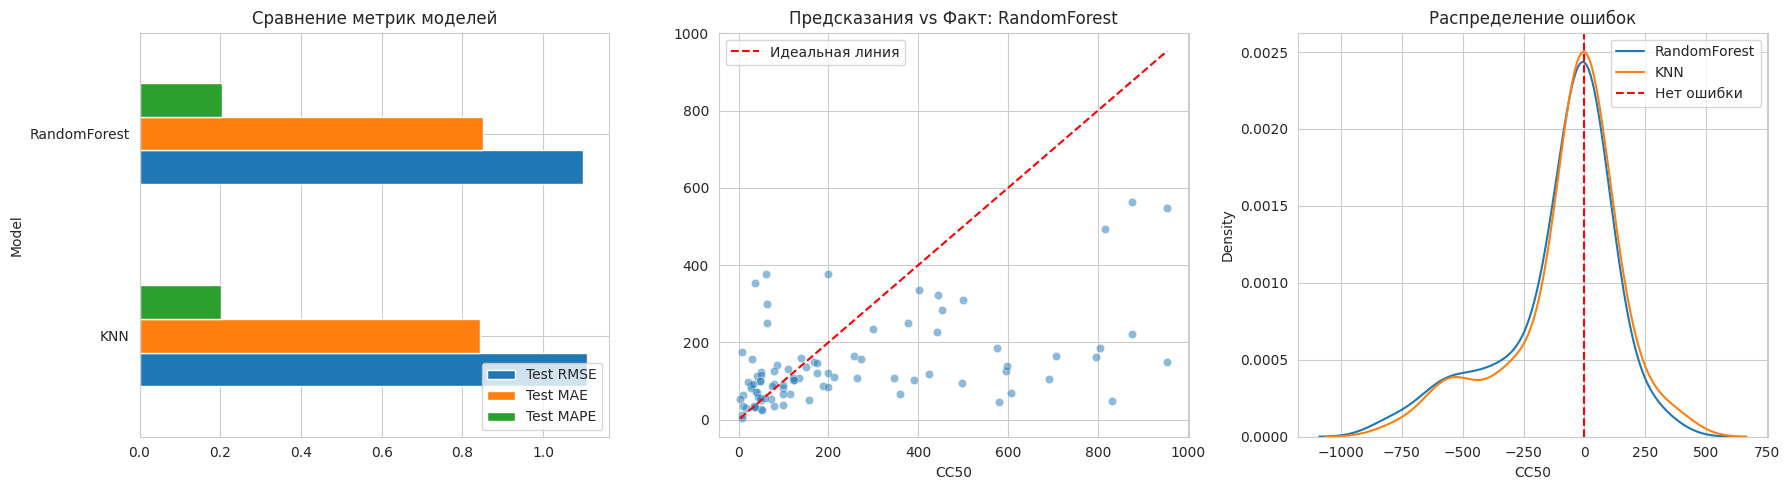

Модель KNN сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_regres_mae_handmade_knn.pkl
Модель RandomForest сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_regres_mae_handmade_randomforest.pkl
Метрики топ-5 моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_regres_mae_handmade_metrics.csv


In [ ]:
# @title ТЮНИНГ RandomForest и CatBoost
random_state=42
from sklearn.ensemble import VotingRegressor, StackingRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

# подготовка данных
metod_name_tuning = 'handmade_tuning'
base_name_tuning = f"{base_parameter}_{analyse_name}_{metod_name_1}"
table_tuning = f"table_{base_name_tuning}.csv"
final_tuning = f"{base_name_tuning}_"

# модели и гиперпараметры
models_tuning = {
    'RandomForest': {
        'model': RandomForestRegressor(random_state=random_state),
        'params': {
            'n_estimators': [400, 500, 600],
            'max_depth': [None],
            'min_samples_split': [2],
            'max_features': ['sqrt']
        }
    },
    'KNN': {
        'model': make_pipeline(
                    StandardScaler(),
                    KNeighborsRegressor()
                ),
        'params': {
            'kneighborsregressor__n_neighbors': [5],
            'kneighborsregressor__weights': ['distance'],
            'kneighborsregressor__p': [1]
        }
    }
}

# инициализация
evaluator_tuning = RegressionModelEvaluator(X1, y1, models_config=models_tuning, metod_name=metod_name_tuning, log_target=True) # ПОМЕНЯТЬ ТУТ!
results = evaluator_tuning.evaluate_models(verbose=True, metrics_filename=table_tuning)
results_tuning = results.copy()

# Диаграмки
visualizer = RegressionResultsVisualizer(evaluator_tuning)
visualizer.visualize_all()

# Сохранение топ-3 моделей
saved_files = evaluator_tuning.save_top_models(n=5, prefix=final_tuning)

In [ ]:
results_tuning

,Metod,Best Parameters,CV MSE,Test MSE,Test RMSE,Test MAE,Test R2,Test Explained Variance,Test Max Error,Test MAPE,Log Target,Model Object,Test MSE (invlog),Test MAE (invlog),Test RMSE (invlog)
Model,,,,,,,,,,,,,,,
KNN,handmade_tuning,"{'kneighborsregressor__n_neighbors': 5, 'kneig...",1.064488,1.229404,1.108785,0.843695,0.271638,0.27738,3.426445,0.202741,True,"(StandardScaler(), KNeighborsRegressor(p=1, we...",57711.815661,152.673998,240.232836
RandomForest,handmade_tuning,"{'max_depth': None, 'max_features': 'sqrt', 'm...",1.049948,1.210261,1.100119,0.850701,0.282979,0.29648,3.127666,0.204585,True,"(DecisionTreeRegressor(max_features='sqrt', ra...",65109.031464,161.690019,255.164714


In [ ]:
print("Best params:", results_tuning.loc['RandomForest', 'Best Parameters'])

Подбор параметров Voting_RandomForest_KNN...
выполнено: Test MAE: 0.832
Подбор параметров Stacking_RandomForest_KNN...
выполнено: Test MAE: 0.989
Метрики всех моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/table_CC50_regres_mae_handmade.csv


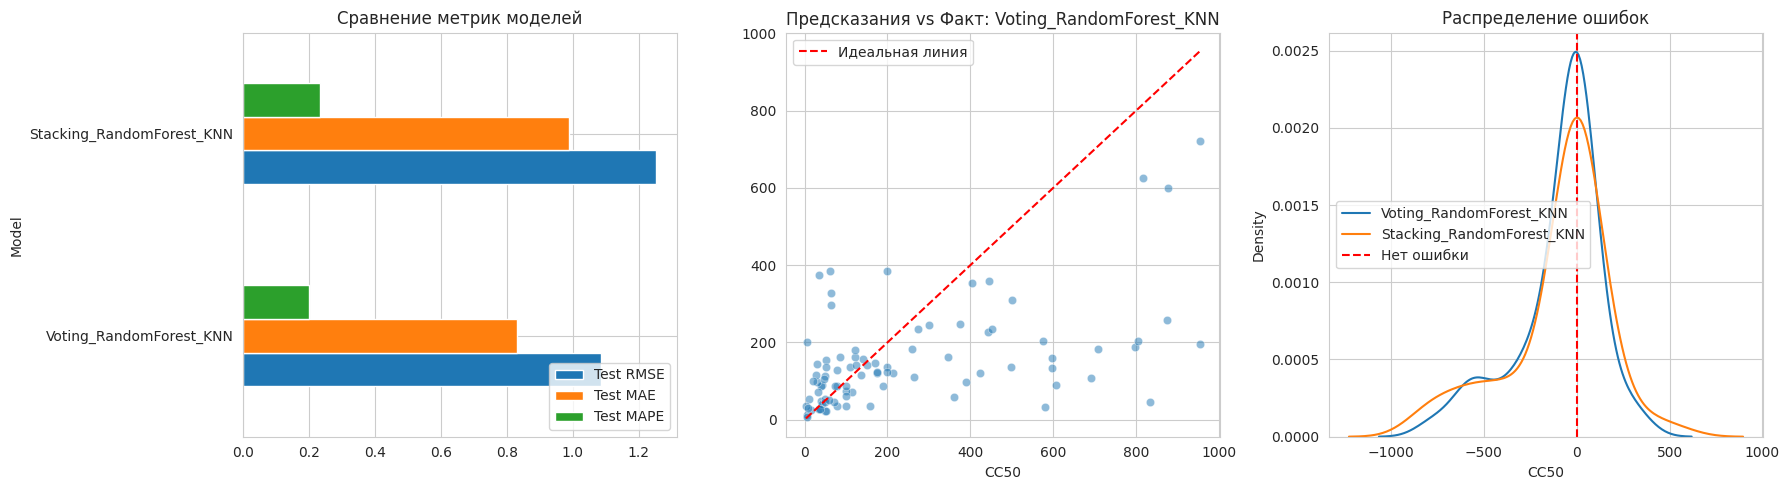

Модель Voting_RandomForest_KNN сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_regres_mae_handmade_voting_randomforest_knn.pkl
Модель Stacking_RandomForest_KNN сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_regres_mae_handmade_stacking_randomforest_knn.pkl
Метрики топ-5 моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_regres_mae_handmade_metrics.csv


In [ ]:
# @title оркестрация RandomForest и CatBoost - Voting и Stacking
random_state=42
from sklearn.ensemble import VotingRegressor, StackingRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

# подготовка данных
metod_name_tuning = 'handmade_tuning'
base_name_tuning = f"{base_parameter}_{analyse_name}_{metod_name_1}"
table_tuning = f"table_{base_name_tuning}.csv"
final_tuning = f"{base_name_tuning}_"

# модели и гиперпараметры
models_tuning = {
    'Voting_RandomForest_KNN': {
        'model': VotingRegressor(
            estimators=[
                ('knn', make_pipeline(
                    StandardScaler(),
                    KNeighborsRegressor()
                )),
                ('random_forest', RandomForestRegressor(random_state=random_state))
            ],
            n_jobs=-1
        ),
        'params': {
            'knn__kneighborsregressor__n_neighbors': [5],
            'knn__kneighborsregressor__weights': ['distance'],
            'knn__kneighborsregressor__p': [1],
            'random_forest__n_estimators': [400],
            'random_forest__max_depth': [None],
            'random_forest__min_samples_split': [2],
            'random_forest__max_features': ['sqrt'],
        }
    },
    'Stacking_RandomForest_KNN': {
        'model': StackingRegressor(
            estimators=[
                ('knn', make_pipeline(
                    StandardScaler(),
                    KNeighborsRegressor(n_neighbors=5)
                )),
                ('random_forest', RandomForestRegressor(random_state=random_state))
            ],
            final_estimator=RandomForestRegressor(random_state=random_state),
            n_jobs=-1
        ),
        'params': {
            'knn__kneighborsregressor__n_neighbors': [5],
            'knn__kneighborsregressor__weights': ['distance'],
            'knn__kneighborsregressor__p': [1],
            'random_forest__n_estimators': [400],
            'random_forest__max_depth': [None],
            'random_forest__min_samples_split': [2],
            'random_forest__max_features': ['sqrt'],
        }
    }
}

# инициализация
evaluator_tuning = RegressionModelEvaluator(X1, y1, models_config=models_tuning, metod_name=metod_name_tuning, log_target=True) # ПОМЕНЯТЬ ТУТ!
results = evaluator_tuning.evaluate_models(verbose=True, metrics_filename=table_tuning)
results_tuning = results.copy()

# Диаграмки
visualizer = RegressionResultsVisualizer(evaluator_tuning)
visualizer.visualize_all()

# Сохранение топ-3 моделей
saved_files = evaluator_tuning.save_top_models(n=5, prefix=final_tuning)

In [ ]:
results_tuning

,Metod,Best Parameters,CV MSE,Test MSE,Test RMSE,Test MAE,Test R2,Test Explained Variance,Test Max Error,Test MAPE,Log Target,Model Object,Test MSE (invlog),Test MAE (invlog),Test RMSE (invlog)
Model,,,,,,,,,,,,,,,
Voting_RandomForest_KNN,handmade_tuning,"{'knn__kneighborsregressor__n_neighbors': 5, '...",1.041095,1.179141,1.085882,0.832154,0.301416,0.311042,3.253850,0.199973,True,"VotingRegressor(estimators=[('knn',\n ...",60390.269297,155.925543,245.744317
Stacking_RandomForest_KNN,handmade_tuning,"{'knn__kneighborsregressor__n_neighbors': 5, '...",1.104587,1.571798,1.253714,0.988808,0.068786,0.079418,2.979758,0.231763,True,"StackingRegressor(estimators=[('knn',\n ...",85148.791668,186.686487,291.802659


In [ ]:
print("Best params:", results_tuning.loc['RandomForest', 'Best Parameters'])